## Perform SMOTE and Test the Results with Hyperparameter Tuning

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE

from yellowbrick.model_selection import validation_curve


## View Results from Hyperparameter Tuning For Current UPDRS
Using the protein and peptide data as well as the visit month, predict the UPDRS value as either Mild, Moderate, or Severe

In [125]:
# read in the data from the csv file for xgboost hyperparameter tuning
xgb_hyperparams_df = pd.read_csv('../data/processed/xgboost_cat_hyperparam_results.csv', index_col=0)
lgb_hyperparams_df = pd.read_csv('../data/processed/lgboost_cat_hyperparam_results.csv', index_col=0)
cboost_hyperparams_df = pd.read_csv('../data/processed/catboost_future_cat_hyperparam_results.csv', index_col=0)

In [126]:
lgb_hyperparams_df

,updrs_1,updrs_2,updrs_3
colsample_bytree,0.629116,0.856101,0.731011
learning_rate,0.628567,0.750618,0.556761
max_depth,5.000000,8.000000,3.000000
min_child_weight,3.578848,16.437261,5.512251
min_split_gain,0.005489,0.000046,0.000197
reg_alpha,7.735830,6.684875,1.484969
reg_lambda,3.493592,3.002659,3.025202
subsample,0.916682,0.882994,0.556561


In [127]:
xgb_hyperparams_df

,updrs_1,updrs_2,updrs_3
colsample_bytree,0.708264,0.694449,0.643855
gamma,1.070175,0.032390,1.949759
learning_rate,0.969325,0.993978,0.502350
max_depth,2.000000,3.000000,2.000000
min_child_weight,0.301500,0.926601,2.980635
reg_alpha,1.641284,5.318046,3.232656
reg_lambda,6.011928,6.999249,7.487927
subsample,0.900018,0.710181,0.885401


In [128]:
cboost_hyperparams_df

,updrs_1,updrs_2,updrs_3
bagging_temperature,4.429427,4.095758,1.162359
depth,7.000000,6.000000,4.000000
l2_leaf_reg,5.641367,5.757078,7.356710
learning_rate,0.366781,0.954836,0.973876
min_data_in_leaf,8.000000,8.000000,4.000000


In [217]:
# read in the protein and updrs data
updrs1_df = pd.read_csv('../data/processed/train_updrs_1_cat.csv')
updrs2_df = pd.read_csv('../data/processed/train_updrs_2_cat.csv')
updrs3_df = pd.read_csv('../data/processed/train_updrs_3_cat.csv')

## Add the Medication Data to the protein data

In [218]:
clin_data = pd.read_csv('../data/raw/train_clinical_data.csv')
clin_data['upd23b_clinical_state_on_medication'] = clin_data['upd23b_clinical_state_on_medication'].fillna('Unknown')

# get dummies for on_medication column
clin_data_dummies = pd.get_dummies(clin_data, columns=['upd23b_clinical_state_on_medication'], drop_first=True)

clin_data_dummies = clin_data_dummies[['visit_id', 'upd23b_clinical_state_on_medication_On', 'upd23b_clinical_state_on_medication_Unknown']]

# merge the updrs data with the clinical data for dummy columns
updrs1_df = pd.merge(updrs1_df, clin_data_dummies, on='visit_id')
updrs2_df = pd.merge(updrs2_df, clin_data_dummies, on='visit_id')
updrs3_df = pd.merge(updrs3_df, clin_data_dummies, on='visit_id')


In [219]:
updrs1_df['updrs_1_cat'].value_counts()

mild        854
moderate    199
severe       15
Name: updrs_1_cat, dtype: int64

In [132]:
updrs2_df['updrs_2_cat'].value_counts()

mild        910
moderate    158
Name: updrs_2_cat, dtype: int64

In [133]:
updrs3_df['updrs_3_cat'].value_counts()

mild        880
moderate    168
severe       10
Name: updrs_3_cat, dtype: int64

In [220]:
# replace the categorical updrs scores with numerical for mild, moderate and severe
## combine the moderate and severe categories since there are very few severe observations
updrs1_df['updrs_1_cat'] = updrs1_df['updrs_1_cat'].map({'mild': 0, 'moderate': 1, 'severe': 1})
updrs2_df['updrs_2_cat'] = updrs2_df['updrs_2_cat'].map({'mild': 0, 'moderate': 1, 'severe': 1})
updrs3_df['updrs_3_cat'] = updrs3_df['updrs_3_cat'].map({'mild': 0, 'moderate': 1, 'severe': 1})

In [221]:
updrs3_df['updrs_3_cat'].value_counts()

0    880
1    178
Name: updrs_3_cat, dtype: int64

In [222]:
updrs3_df.columns

Index(['visit_id', 'patient_id', 'visit_month', 'updrs_3', 'O00391', 'O00533',
       'O00584', 'O14498', 'O14773', 'O14791',
       ...
       'YYC(UniMod_4)FQGNQFLR_P02790', 'YYTYLIMNK_P01024',
       'YYWGGQYTWDMAK_P02675', 'kfold', 'num_prot_pep', 'num_prot', 'num_pept',
       'updrs_3_cat', 'upd23b_clinical_state_on_medication_On',
       'upd23b_clinical_state_on_medication_Unknown'],
      dtype='object', length=1206)

In [223]:
## create smote function
def smote_data(df, target):
    """
    Function to perform SMOTE on a dataframe with a target variable
    """
    # separate the target variable from the dataframe
    X = df.drop(columns=target)
    y = df[target]
    
    # perform smote on the data
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X, y)
    
    # create a dataframe from the smote data
    X_smote_df = pd.DataFrame(X_smote, columns=X.columns)
    y_smote_df = pd.DataFrame(y_smote, columns=[target])
    
    # combine the X and y smote dataframes
    smote_df = pd.concat([X_smote_df, y_smote_df], axis=1)
    
    return smote_df

## Perform Validation Curve on XGBoost Fine Tune Parameters
- max-depth
- subsampling
- gamma
- reg_alpha
- reg_lambda
- scale_pos_weight

In [224]:
updrs1_df_smote = smote_data(updrs1_df[updrs1_df['kfold']!=0], 'updrs_1_cat')

In [225]:
updrs1_test_df = updrs1_df[updrs1_df['kfold']==0]

In [226]:
updrs1_df_smote['updrs_1_cat'].value_counts()

1    683
0    683
Name: updrs_1_cat, dtype: int64

c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgbo

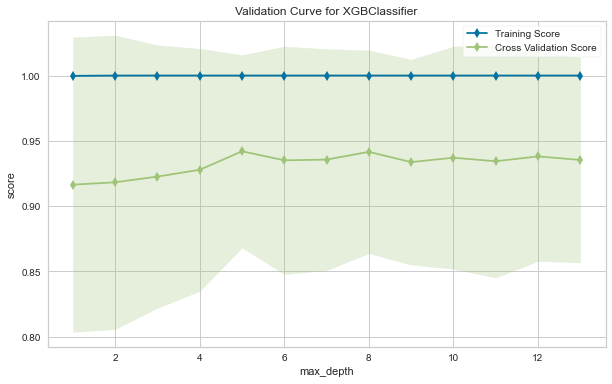

In [141]:
# prep the dataframe for validation curve
train1_df = updrs1_df_smote.drop(columns = ['visit_id', 'patient_id', 'kfold', 'updrs_1'])
X_train_df = train1_df.drop(columns = ['updrs_1_cat'])
y_train_df = train1_df['updrs_1_cat']
updrs1_xgb_params = xgb_hyperparams_df['updrs_1'].to_dict()
# plot the validation curve for the xgboost model
fig, ax = plt.subplots(figsize=(10, 6))
viz = validation_curve(XGBClassifier(**updrs1_xgb_params), X_train_df, y_train_df, param_name='max_depth', param_range=range(1, 14), cv=4, scoring='roc_auc', ax=ax)


In [142]:
viz.test_scores_mean_, viz.test_scores_std_

(array([0.9164314 , 0.91826947, 0.92262652, 0.92784019, 0.94197486,
        0.93508078, 0.93561674, 0.94156638, 0.93369921, 0.93707501,
        0.9343442 , 0.93807019, 0.93536568]),
 array([0.11272353, 0.11241454, 0.10049732, 0.09270698, 0.07367254,
        0.08711537, 0.08460111, 0.07762859, 0.07850092, 0.08505647,
        0.08898804, 0.08003189, 0.07844998]))

### Max Depth = 1 is the best AUC for UPDRS_1

c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgbo

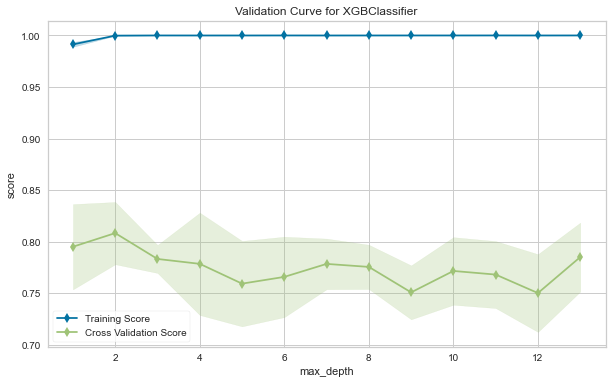

In [143]:
# prep the dataframe for validation curve
train2_df = updrs2_df.drop(columns = ['visit_id', 'patient_id', 'kfold', 'updrs_2'])
X_train_df = train2_df.drop(columns = ['updrs_2_cat'])
y_train_df = train2_df['updrs_2_cat']
updrs1_xgb_params = xgb_hyperparams_df['updrs_2'].to_dict()
# plot the validation curve for the xgboost model
fig, ax = plt.subplots(figsize=(10, 6))
viz = validation_curve(XGBClassifier(**updrs1_xgb_params), X_train_df, y_train_df, param_name='max_depth', param_range=range(1, 14), cv=4, scoring='roc_auc', ax=ax)


In [144]:
# view the results for updrs 2
viz.test_scores_mean_, viz.test_scores_std_

(array([0.7950222 , 0.80824946, 0.78317145, 0.77844014, 0.75922958,
        0.76577413, 0.7783817 , 0.77546744, 0.75076115, 0.77153435,
        0.76802938, 0.75009315, 0.78496646]),
 array([0.0413646 , 0.03019884, 0.0135695 , 0.04962678, 0.04143541,
        0.03899145, 0.02454322, 0.02146014, 0.02614738, 0.03277674,
        0.03247164, 0.03770306, 0.03344752]))

### UPDRS 2 Max Depth = 2 has the best AUC score

In [145]:
from yellowbrick.model_selection import ValidationCurve

c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgbo

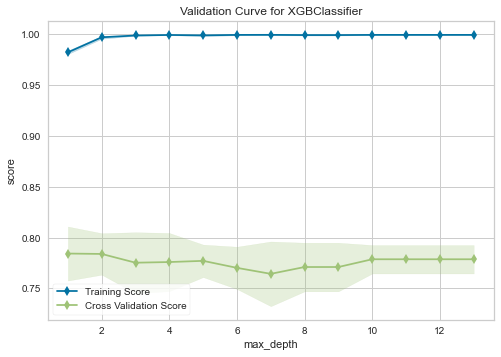

<AxesSubplot:title={'center':'Validation Curve for XGBClassifier'}, xlabel='max_depth', ylabel='score'>

In [146]:
# prep the dataframe for validation curve
train3_df = updrs3_df.drop(columns = ['visit_id', 'patient_id', 'kfold', 'updrs_3'])
X_train_df = train3_df.drop(columns = ['updrs_3_cat'])
y_train_df = train3_df['updrs_3_cat']
updrs1_xgb_params = xgb_hyperparams_df['updrs_3'].to_dict()
# plot the validation curve for the xgboost model
# Create an instance of ValidationCurve
viz = ValidationCurve(
    XGBClassifier(**updrs1_xgb_params, verbosity=0, silent=True),  #  Classifier object
    param_name="max_depth",  # The parameter to validate
    param_range=range(1, 14),  # The parameter values to evaluate
    cv=4,  # Number of cross-validation folds
    scoring="roc_auc",  # Scoring metric for evaluation
    n_jobs=-1,  # Number of CPU cores to use (set to -1 to use all available cores)
)

# Fit the validation curve on your training data
viz.fit(X_train_df, y_train_df)  # Replace X and y with your training data

# Visualize the validation curve
viz.poof()

In [147]:
# view the results for updrs 3
viz.test_scores_mean_, viz.test_scores_std_

(array([0.78432105, 0.78392103, 0.77532427, 0.77596247, 0.77713786,
        0.7702508 , 0.76437787, 0.77107897, 0.77107897, 0.77869777,
        0.77869777, 0.77869777, 0.77869777]),
 array([0.02654547, 0.02037855, 0.02994284, 0.02857281, 0.01595861,
        0.02076963, 0.03177682, 0.02387242, 0.02387242, 0.01394949,
        0.01394949, 0.01394949, 0.01394949]))

### Simplest Decent Model with good AUC is Max Depth = 2, but the best with low std is Max Depth = 10

In [148]:

def cross_fold_validation(df, model, target):

    updrs_results = dict()
    
    for fold in range(1, 5):
        # get the train and test data for the current fold
        train = df[df['kfold'] != fold].reset_index(drop=True)
        test = df[df['kfold'] == fold].reset_index(drop=True)

        # get the train and test data for the current fold
        drop_cols = ['visit_id', 'patient_id', f'{target}', 'kfold', f'{target}_cat']
        X_train = train.drop(columns=drop_cols)
        y_train = train[f'{target}_cat']
        X_test = test.drop(columns=drop_cols)
        y_test = test[f'{target}_cat']

        # train the model
        model.fit(X_train, y_train)

        # make predictions
        preds = model.predict(X_test)


        # save the results
        updrs_results[f'{target}_fold_{fold}'] = {
            'auc_score': roc_auc_score(y_test, preds),
            'acc_score': accuracy_score(y_test, preds),
            'precision_score': precision_score(y_test, preds),
            'recall_score': recall_score(y_test, preds),
        }
        
    mean_auc = np.mean([updrs_results[f'{target}_fold_{fold}']['auc_score'] for fold in range(1, 5)])
    mean_acc = np.mean([updrs_results[f'{target}_fold_{fold}']['acc_score'] for fold in range(1, 5)])
    mean_precision = np.mean([updrs_results[f'{target}_fold_{fold}']['precision_score'] for fold in range(1, 5)])
    mean_recall = np.mean([updrs_results[f'{target}_fold_{fold}']['recall_score'] for fold in range(1, 5)])
    
    return mean_auc, mean_acc, mean_precision, mean_recall
        
    
    

In [227]:
def prepare_xgboost_model(xgb_hyperparams_df, target):
    # train the model using the hyperparameters from the hyperparameter tuning
    updrs_hp = xgb_hyperparams_df[target].to_dict()
    if target == 'updrs_1':
        updrs_hp['max_depth'] = 1
    else:
        updrs_hp['max_depth'] = 2
    
    updrs_hp['verbosity'] = 0
    updrs_hp['silent'] = True
    updrs_hp['random_state'] = 42
    
    model = XGBClassifier(**updrs_hp)
    
    return model

In [228]:
def prepare_lgboost_model(lgb_hyperparams_df, target):
    # train the model using the hyperparameters from the hyperparameter tuning
    updrs_hp = lgb_hyperparams_df[target].to_dict()
    if target == 'updrs_1':
        updrs_hp['max_depth'] = 1
    else:
        updrs_hp['max_depth'] = 2
    
    updrs_hp['random_state'] = 42
    
    model = LGBMClassifier(**updrs_hp)
    
    return model

In [229]:
def prepare_catboost_model(cboost_hyperparams_df, target):
    # train the model using the hyperparameters from the hyperparameter tuning
    updrs_hp = cboost_hyperparams_df[target].to_dict()
    if target == 'updrs_1':
        updrs_hp['depth'] = 1
    else:
        updrs_hp['depth'] = 2
    
    updrs_hp['random_state'] = 42
    
    model = CatBoostClassifier(**updrs_hp)
    
    return model

In [152]:
# test the model function
# model = prepare_xgboost_model(xgb_hyperparams_df, 'updrs_1')
# model.get_params()

In [153]:
xgb_results = dict()

for updrs, df in zip(['updrs_1'], [updrs1_df]):
    model = prepare_xgboost_model(xgb_hyperparams_df, updrs)
    auc, acc, prec, recall = cross_fold_validation(df, model, updrs)
    xgb_results[updrs] = {"auc":auc,
                        "acc":acc,
                        "prec":prec,
                        "recall":recall}

c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgbo

In [154]:
xgb_results

{'updrs_1': {'auc': 0.6287939411687982,
  'acc': 0.8056195428019832,
  'prec': 0.5441299403774049,
  'recall': 0.33382368965892995}}

In [155]:
model = prepare_xgboost_model(xgb_hyperparams_df, 'updrs_1')
X_train_df = updrs1_df_smote.drop(columns = ['updrs_1_cat', 'visit_id', 'patient_id', 'kfold', 'updrs_1'])
y_train_df = updrs1_df_smote['updrs_1_cat']
X_test = updrs1_test_df.drop(columns = ['updrs_1_cat', 'visit_id', 'patient_id', 'kfold', 'updrs_1'])
y_test = updrs1_test_df['updrs_1_cat']

model.fit(X_train_df, y_train_df)

preds = model.predict_proba(X_test)[:,-1]

c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [156]:
roc_auc_score(y_test, preds), accuracy_score(y_test, preds>0.4), precision_score(y_test, preds>0.4), recall_score(y_test, preds>0.4)

(0.7192982456140351,
 0.7710280373831776,
 0.4423076923076923,
 0.5348837209302325)

In [157]:
def plot_precision_recall_accuracy(y_test, preds, updrs, model_name):
    thresholds = np.linspace(0, 1.0, num=100)  # Generating 100 threshold values between 0 and 1.0
    precisions = []
    recalls = []
    accuracies = []
    f1 = []

    for threshold in thresholds:
        # Convert probabilities to binary predictions based on the threshold
        binary_preds = np.where(preds >= threshold, 1, 0)

        # Calculate precision, recall, and accuracy scores
        precision = precision_score(y_test, binary_preds)
        recall = recall_score(y_test, binary_preds)
        accuracy = accuracy_score(y_test, binary_preds)
        f1_score = 2 * (precision * recall) / (precision + recall)

        # Append scores to the respective lists
        precisions.append(precision)
        recalls.append(recall)
        accuracies.append(accuracy)
        f1.append(f1_score)

    # Plot precision, recall, and accuracy against thresholds
    plt.plot(thresholds, precisions, label='Precision')
    plt.plot(thresholds, recalls, label='Recall')
    plt.plot(thresholds, accuracies, label='Accuracy')
    plt.plot(thresholds, f1, label='F1 Score')

    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title(f'{model_name} - {updrs}: Precision, Recall, F1 and Accuracy for Thresholds')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return max(f1), thresholds[f1.index(max(f1))]
    

c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


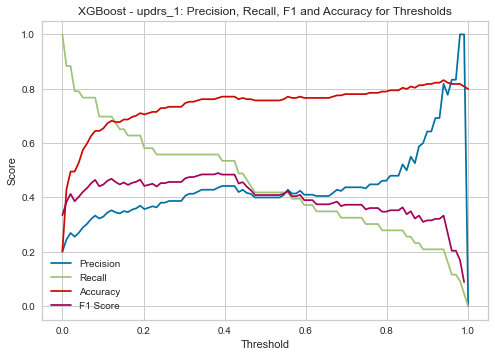

In [158]:
max_f1, thresh_ind = plot_precision_recall_accuracy(y_test, preds, "updrs_1", "XGBoost")

In [159]:
roc_auc_score(y_test, preds>0.33), accuracy_score(y_test, preds>0.33), precision_score(y_test, preds>0.33), recall_score(y_test, preds>0.33)

(0.679654562763498,
 0.7523364485981309,
 0.41379310344827586,
 0.5581395348837209)

## View XGBoost Results with Forecasting the UPDRS

In [230]:
# get the max category for each patient
max_df = updrs1_df.groupby(['patient_id'])['updrs_1_cat'].max().reset_index()
max_df = max_df.rename(columns={'updrs_1_cat': 'updrs_1_max_cat'})
# merge the max category with the original dataframe
updrs1_df = updrs1_df.merge(max_df, on=['patient_id'], how='left')
# take only the visit months that are 12 or less
updrs1_yr_df = updrs1_df[updrs1_df['visit_month'] <= 12]
updrs1_yr_df = updrs1_yr_df.drop(columns=['updrs_1_cat'])
updrs1_yr_df.rename(columns={'updrs_1_max_cat': 'updrs_1_cat'}, inplace=True)

In [231]:
# get the max category for each patient
max_df = updrs2_df.groupby(['patient_id'])['updrs_2_cat'].max().reset_index()
max_df = max_df.rename(columns={'updrs_2_cat': 'updrs_2_max_cat'})
# merge the max category with the original dataframe
updrs2_df = updrs2_df.merge(max_df, on=['patient_id'], how='left')
# take only the visit months that are 12 or less
updrs2_yr_df = updrs2_df[updrs2_df['visit_month'] <= 12]
updrs2_yr_df = updrs2_yr_df.drop(columns=['updrs_2_cat'])
updrs2_yr_df.rename(columns={'updrs_2_max_cat': 'updrs_2_cat'}, inplace=True)

In [232]:
# get the max category for each patient
max_df = updrs3_df.groupby(['patient_id'])['updrs_3_cat'].max().reset_index()
max_df = max_df.rename(columns={'updrs_3_cat': 'updrs_3_max_cat'})
# merge the max category with the original dataframe
updrs3_df = updrs3_df.merge(max_df, on=['patient_id'], how='left')
# take only the visit months that are 12 or less
updrs3_yr_df = updrs3_df[updrs3_df['visit_month'] <= 12]
updrs3_yr_df = updrs3_yr_df.drop(columns=['updrs_3_cat'])
updrs3_yr_df.rename(columns={'updrs_3_max_cat': 'updrs_3_cat'}, inplace=True)

In [233]:
updrs1_yr_test = updrs1_yr_df[updrs1_yr_df['kfold']==0]
updrs2_yr_test = updrs2_yr_df[updrs2_yr_df['kfold']==0]
updrs3_yr_test = updrs3_yr_df[updrs3_yr_df['kfold']==0]

updrs1_yr_df_smote = smote_data(updrs1_yr_df[updrs1_yr_df['kfold']!=0], 'updrs_1_cat')
updrs2_yr_df_smote = smote_data(updrs2_yr_df[updrs2_yr_df['kfold']!=0], 'updrs_2_cat')
updrs3_yr_df_smote = smote_data(updrs3_yr_df[updrs3_yr_df['kfold']!=0], 'updrs_3_cat')

In [234]:
xgb_forecast_hyperparams_df = pd.read_csv('../data/processed/xgboost_future_cat_hyperparam_results.csv', index_col=0)
lgb_forecast_hyperparams_df = pd.read_csv('../data/processed/lgboost_future_cat_hyperparam_results.csv', index_col=0)
cboost_forecast_hyperparams_df = pd.read_csv('../data/processed/catboost_future_cat_hyperparam_results.csv', index_col=0)



In [235]:
lgb_forecast_hyperparams_df

,updrs_1,updrs_2,updrs_3
colsample_bytree,0.970757,0.903629,0.686326
learning_rate,0.983567,0.174551,0.910126
max_depth,8.000000,2.000000,6.000000
min_child_weight,1.232586,2.797518,13.387500
min_split_gain,0.007964,0.297876,0.004011
reg_alpha,7.437594,1.543678,4.159710
reg_lambda,7.499285,3.401574,1.926977
subsample,0.728666,0.948910,0.839655


In [236]:
xgb_forecast_hyperparams_df.loc['max_depth', 'updrs_1'] = 1
xgb_forecast_hyperparams_df.loc['max_depth', 'updrs_2'] = 2
xgb_forecast_hyperparams_df.loc['max_depth', 'updrs_3'] = 2
xgb_forecast_hyperparams_df

,updrs_1,updrs_2,updrs_3
colsample_bytree,0.999434,0.972336,0.579427
gamma,0.218284,0.108280,0.000070
learning_rate,0.876356,0.650330,0.759742
max_depth,1.000000,2.000000,2.000000
min_child_weight,0.292568,7.076801,0.642850
reg_alpha,6.803953,2.521598,2.426225
reg_lambda,1.268909,1.677160,3.504071
subsample,0.535242,0.682804,0.693480


In [237]:
cboost_hyperparams_df

,updrs_1,updrs_2,updrs_3
bagging_temperature,4.429427,4.095758,1.162359
depth,7.000000,6.000000,4.000000
l2_leaf_reg,5.641367,5.757078,7.356710
learning_rate,0.366781,0.954836,0.973876
min_data_in_leaf,8.000000,8.000000,4.000000


In [238]:
xgb_forecast_hyperparams_df.loc['gamma', 'updrs_1'] = 0.6
xgb_forecast_hyperparams_df.loc['subsample', 'updrs_1'] = 0.9
# xgb_forecast_hyperparams_df.loc['scale_pos_weight', 'updrs_1'] = 1.5
# xgb_forecast_hyperparams_df.loc['scale_pos_weight', 'updrs_2'] = 2.2
# xgb_forecast_hyperparams_df.loc['scale_pos_weight', 'updrs_3'] = 1.6

In [239]:
xgb_forecast_hyperparams_df

,updrs_1,updrs_2,updrs_3
colsample_bytree,0.999434,0.972336,0.579427
gamma,0.600000,0.108280,0.000070
learning_rate,0.876356,0.650330,0.759742
max_depth,1.000000,2.000000,2.000000
min_child_weight,0.292568,7.076801,0.642850
reg_alpha,6.803953,2.521598,2.426225
reg_lambda,1.268909,1.677160,3.504071
subsample,0.900000,0.682804,0.693480


In [240]:
xgb_forecast_results = dict()

for updrs, df in zip(['updrs_1', 'updrs_2', 'updrs_3'], [updrs1_yr_df_smote, updrs2_yr_df_smote, updrs3_yr_df_smote]):
    model = prepare_xgboost_model(xgb_forecast_hyperparams_df, updrs)
    print(f'UPDRS: {updrs}')
    print(f'Hyperparameters: {model.get_params()}')
    print('\n')
    auc, acc, prec, recall = cross_fold_validation(df, model, updrs)
    xgb_forecast_results[updrs] = {"auc":auc,
                        "acc":acc,
                        "prec":prec,
                        "recall":recall}

UPDRS: updrs_1
Hyperparameters: {'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9994339895225436, 'gamma': 0.6, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.8763564203413519, 'max_delta_step': None, 'max_depth': 1, 'min_child_weight': 0.2925675445213144, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 6.803952572268468, 'reg_lambda': 1.2689093632909028, 'scale_pos_weight': None, 'subsample': 0.9, 'tree_method': None, 'validate_parameters': None, 'verbosity': 0, 'silent': True}




c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgbo

UPDRS: updrs_2
Hyperparameters: {'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9723358597087076, 'gamma': 0.1082797129959026, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.6503304038389104, 'max_delta_step': None, 'max_depth': 2, 'min_child_weight': 7.076800505115973, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 2.5215977214254304, 'reg_lambda': 1.677159748913182, 'scale_pos_weight': None, 'subsample': 0.6828035084965419, 'tree_method': None, 'validate_parameters': None, 'verbosity': 0, 'silent': True}




c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgbo

UPDRS: updrs_3
Hyperparameters: {'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.5794273693429098, 'gamma': 6.958373374993177e-05, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.7597417382901697, 'max_delta_step': None, 'max_depth': 2, 'min_child_weight': 0.6428495541542038, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 2.426225167246236, 'reg_lambda': 3.5040708421969304, 'scale_pos_weight': None, 'subsample': 0.6934802250073431, 'tree_method': None, 'validate_parameters': None, 'verbosity': 0, 'silent': True}




c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgbo

In [241]:
xgb_forecast_results

{'updrs_1': {'auc': 0.7056210479124556,
  'acc': 0.7013887792033141,
  'prec': 0.7337825696316261,
  'recall': 0.6337685074029612},
 'updrs_2': {'auc': 0.8060948103244917,
  'acc': 0.804269772422878,
  'prec': 0.8063661073297841,
  'recall': 0.8007450882450882},
 'updrs_3': {'auc': 0.710470716978248,
  'acc': 0.7099805050305036,
  'prec': 0.7339424141749723,
  'recall': 0.6571603740534131}}

In [242]:


def create_folds(df, target):
    # calculate the number of bins by Sturge's rule
    num_bins = int(np.floor(1 + np.log2(len(df))))
    df.loc[:, "bins"] = pd.cut(df[f'{updrs}_cat'], bins=num_bins, labels=False)

    df = df.dropna().reset_index(drop=True)
        
    # initiate the kfold class from sklearn
    kf = StratifiedKFold(n_splits=5)
        
    # create a kfold column
    df['kfold'] = -1

    # fill the kfold column
    for f, (t_, v_) in enumerate(kf.split(X=df, y=df['bins'].values)):
        df.loc[v_, 'kfold'] = f
            
    # drop the bins column
    df = df.drop('bins', axis=1)
    max_kfold = df['kfold'].max()
    
    print(f'{max_kfold + 1} Kfolds created for {target}_cat')
    return df, max_kfold

In [243]:
def train_xgboost(train_df, test_df, updrs, model):
    features = train_df.drop([f'{updrs}_cat', 'kfold'], axis=1)
    target = train_df[f'{updrs}_cat']
    X_test = test_df.drop([f'{updrs}_cat', 'kfold'], axis=1)
    y_test = test_df[f'{updrs}_cat']


    model.fit(features, target)
    
    # Make predictions on the test data
    predictions = model.predict_proba(X_test)[:, 1]

    # Evaluate AUC on the test data
    auc = roc_auc_score(y_test, predictions)
    print("AUC on Test Data:", auc)


    # Save the trained model to a file
    filename =f'../models/xgboost_{updrs}_model_max_depth_meds.sav'
    pickle.dump(model, open(filename, 'wb'))

    return model

In [244]:
for updrs, df, test_df in zip(['updrs_1', 'updrs_2', 'updrs_3'], 
                     [updrs1_yr_df_smote, updrs2_yr_df_smote, updrs3_yr_df_smote],
                     [updrs1_yr_test, updrs2_yr_test, updrs3_yr_test]):
    model = prepare_xgboost_model(xgb_forecast_hyperparams_df, updrs)
    train_df = df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    test_df = test_df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    y_test = test_df[f'{updrs}_cat']
    y_train = train_df[f'{updrs}_cat']
    
    best_model = train_xgboost(train_df, test_df, updrs, model)
    # compare the results of the model
    X_test = test_df.drop(columns=[f'{updrs}_cat', 'kfold'])
    test_preds = best_model.predict_proba(X_test)[:, 1]

    test_auc = roc_auc_score(y_test, test_preds)
    X_train = train_df.drop(columns=[f'{updrs}_cat', 'kfold'])
    train_preds = best_model.predict(X_train)
    train_auc = roc_auc_score(y_train, train_preds)
    print(f'{updrs} Results: \nTest AUC = {test_auc} \nTrain AUC = {train_auc}\n')
    


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7214206437291897
updrs_1 Results: 
Test AUC = 0.7214206437291897 
Train AUC = 0.9377777777777778



c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7549206349206349
updrs_2 Results: 
Test AUC = 0.7549206349206349 
Train AUC = 1.0



c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC on Test Data: 0.7028301886792454
updrs_3 Results: 
Test AUC = 0.7028301886792454 
Train AUC = 1.0



c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to

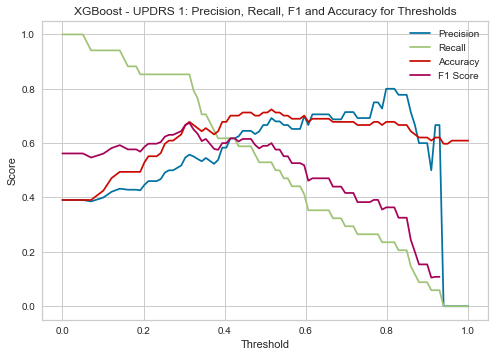

ROC-AUC: 0.7214206437291897 
Accuracy: 0.6666666666666666 
Precision: 0.5471698113207547 
Recall: 0.8529411764705882 
Threshold: 0.31


In [247]:
# Load the saved model
model = joblib.load('../models/xgboost_updrs_1_model_max_depth_meds.sav')

# Make predictions on the test data
X_test1 = updrs1_yr_test.drop(columns=['updrs_1_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_1'])
y_test1 = updrs1_yr_test['updrs_1_cat']

preds = model.predict_proba(X_test1)[:, 1]


plot_precision_recall_accuracy(y_test1, preds, 'UPDRS 1', 'XGBoost')

print("ROC-AUC:", roc_auc_score(y_test1, preds),\
    "\nAccuracy:", accuracy_score(y_test1, preds>0.31), \
    "\nPrecision:", precision_score(y_test1, preds>0.31), \
    "\nRecall:", recall_score(y_test1, preds>0.31), \
        "\nThreshold: 0.31")

0.7549206349206349 0.7159090909090909 0.5 0.64


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\Dagart\anaconda3\envs\easypy3

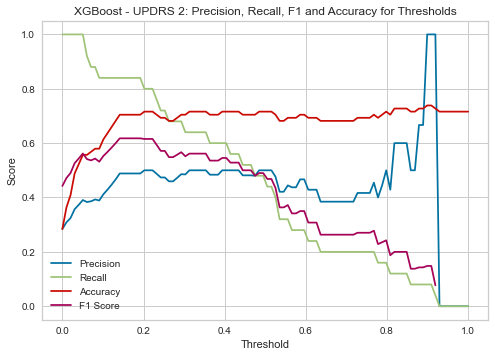

ROC-AUC: 0.7549206349206349 
Accuracy: 0.7159090909090909 
Precision: 0.5 
Recall: 0.8 
Threshold: 0.2


In [250]:
# Load the saved model
model = joblib.load('../models/xgboost_updrs_2_model_max_depth_meds.sav')

# Make predictions on the test data
X_test2 = updrs2_yr_test.drop(columns=['updrs_2_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_2'])
y_test2 = updrs2_yr_test['updrs_2_cat']

preds = model.predict_proba(X_test2)[:, 1]

print(roc_auc_score(y_test2, preds), accuracy_score(y_test2, preds>0.33), precision_score(y_test2, preds>0.33), recall_score(y_test2, preds>0.33))

plot_precision_recall_accuracy(y_test2, preds, 'UPDRS 2', 'XGBoost')

print("ROC-AUC:", roc_auc_score(y_test2, preds),\
    "\nAccuracy:", accuracy_score(y_test2, preds>0.2), \
    "\nPrecision:", precision_score(y_test2, preds>0.2), \
    "\nRecall:", recall_score(y_test2, preds>0.2), \
    "\nThreshold: 0.2")

0.7028301886792454 0.5529411764705883 0.45 0.84375


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\Dagart\anaconda3\envs\easypy3

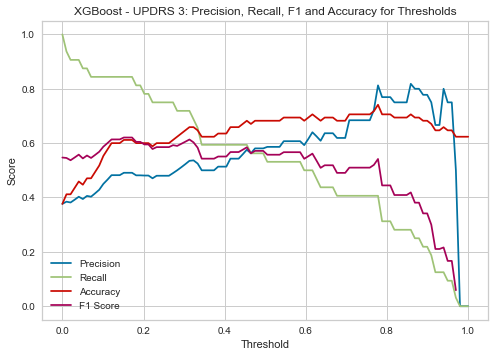

ROC-AUC: 0.7028301886792454 
Accuracy: 0.6588235294117647 
Precision: 0.5348837209302325 
Recall: 0.71875 
Threshold: 0.31


In [249]:
# Load the saved model
model = joblib.load('../models/xgboost_updrs_3_model_max_depth_meds.sav')

# Make predictions on the test data
X_test3 = updrs3_yr_test.drop(columns=['updrs_3_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_3'])
y_test3 = updrs3_yr_test['updrs_3_cat']

preds = model.predict_proba(X_test3)[:, 1]

print(roc_auc_score(y_test3, preds), accuracy_score(y_test3, preds>0.1), precision_score(y_test3, preds>0.1), recall_score(y_test3, preds>0.1))

plot_precision_recall_accuracy(y_test3, preds, 'UPDRS 3', 'XGBoost')

print("ROC-AUC:", roc_auc_score(y_test3, preds),\
    "\nAccuracy:", accuracy_score(y_test3, preds>0.31), \
    "\nPrecision:", precision_score(y_test3, preds>0.31), \
    "\nRecall:", recall_score(y_test3, preds>0.31), \
    "\nThreshold: 0.31")


## LGBoost Future Categorical Predictions

In [251]:
def train_lgboost(train_df, test_df, updrs, model):
    features = train_df.drop([f'{updrs}_cat', 'kfold'], axis=1)
    target = train_df[f'{updrs}_cat']
    X_test = test_df.drop([f'{updrs}_cat', 'kfold'], axis=1)
    y_test = test_df[f'{updrs}_cat']


    model.fit(features, target)
    
    # Make predictions on the test data
    predictions = model.predict_proba(X_test)[:, 1]

    # Evaluate AUC on the test data
    auc = roc_auc_score(y_test, predictions)
    print("AUC on Test Data:", auc)


    # Save the trained model to a file
    filename = f'../models/lgboost_{updrs}_model_max_depth_meds.pkl'
    joblib.dump(model, filename)

    return model

In [252]:
for updrs, df, test_df in zip(['updrs_1', 'updrs_2', 'updrs_3'], 
                     [updrs1_yr_df_smote, updrs2_yr_df_smote, updrs3_yr_df_smote],
                     [updrs1_yr_test, updrs2_yr_test, updrs3_yr_test]):
    model = prepare_lgboost_model(lgb_forecast_hyperparams_df, updrs)
    train_df = df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    test_df = test_df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    y_test = test_df[f'{updrs}_cat']
    y_train = train_df[f'{updrs}_cat']
    
    best_model = train_lgboost(train_df, test_df, updrs, model)
    # compare the results of the model
    X_test = test_df.drop(columns=[f'{updrs}_cat', 'kfold'])
    test_preds = best_model.predict_proba(X_test)[:, 1]

    test_auc = roc_auc_score(y_test, test_preds)
    X_train = train_df.drop(columns=[f'{updrs}_cat', 'kfold'])
    train_preds = best_model.predict(X_train)
    train_auc = roc_auc_score(y_train, train_preds)
    print(f'{updrs} Results: \nTest AUC = {test_auc} \nTrain AUC = {train_auc}\n')
    


AUC on Test Data: 0.7142064372918979
updrs_1 Results: 
Test AUC = 0.7142064372918979 
Train AUC = 0.9222222222222222

AUC on Test Data: 0.8323809523809524
updrs_2 Results: 
Test AUC = 0.8323809523809524 
Train AUC = 1.0

AUC on Test Data: 0.6191037735849056
updrs_3 Results: 
Test AUC = 0.6191037735849056 
Train AUC = 1.0



0.7142064372918979 0.5172413793103449 0.4375 0.8235294117647058


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\Dagart\anaconda3\envs\easypy3

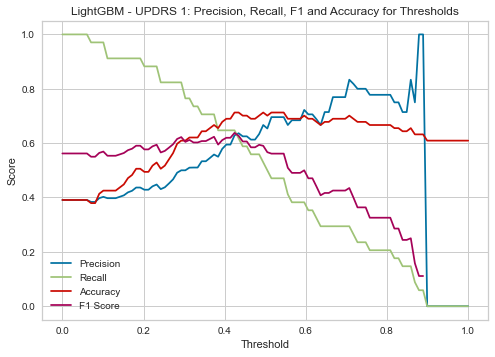

ROC-AUC: 0.7142064372918979 
Accuracy: 0.6091954022988506 
Precision: 0.5 
Recall: 0.7647058823529411 
Threshold: 0.3


In [253]:
# Load the saved model
model = joblib.load('../models/lgboost_updrs_1_model_max_depth_meds.pkl')

# Make predictions on the test data
X_test1 = updrs1_yr_test.drop(columns=['updrs_1_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_1'])
y_test1 = updrs1_yr_test['updrs_1_cat']

preds = model.predict_proba(X_test1)[:, 1]

print(roc_auc_score(y_test1, preds), accuracy_score(y_test1, preds>0.25), precision_score(y_test1, preds>0.25), recall_score(y_test1, preds>0.25))

plot_precision_recall_accuracy(y_test1, preds, 'UPDRS 1', 'LightGBM')

print("ROC-AUC:", roc_auc_score(y_test1, preds),\
    "\nAccuracy:", accuracy_score(y_test1, preds>0.3), \
    "\nPrecision:", precision_score(y_test1, preds>0.3), \
    "\nRecall:", recall_score(y_test1, preds>0.3), \
    "\nThreshold: 0.3")

c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\Dagart\anaconda3\envs\easypy3

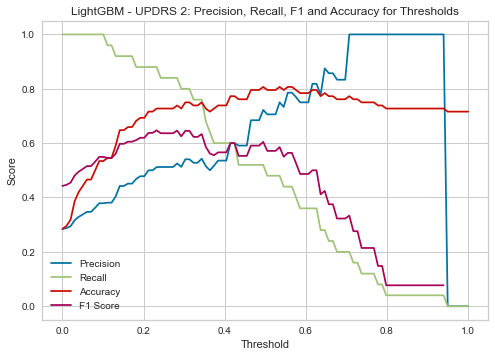

ROC-AUC: 0.8323809523809524 
Accuracy: 0.75 
Precision: 0.5405405405405406 
Recall: 0.8 
Threshold: 0.31


In [256]:

# Load the saved model
model = joblib.load('../models/lgboost_updrs_2_model_max_depth_meds.pkl')

# Make predictions on the test data
X_test2 = updrs2_yr_test.drop(columns=['updrs_2_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_2'])
y_test2 = updrs2_yr_test['updrs_2_cat']

preds = model.predict_proba(X_test2)[:, 1]


plot_precision_recall_accuracy(y_test2, preds, 'UPDRS 2', 'LightGBM')

print("ROC-AUC:", roc_auc_score(y_test2, preds),\
    "\nAccuracy:", accuracy_score(y_test2, preds>0.31), \
    "\nPrecision:", precision_score(y_test2, preds>0.31), \
    "\nRecall:", recall_score(y_test2, preds>0.31), \
    "\nThreshold: 0.31")


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\Dagart\anaconda3\envs\easypy3

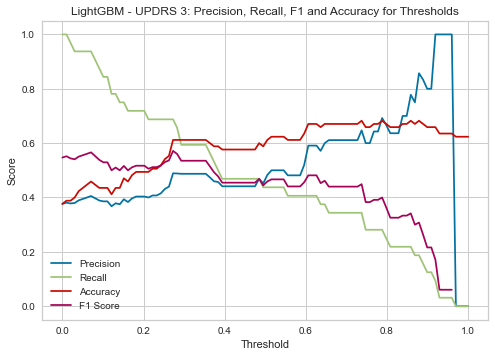

ROC-AUC: 0.6191037735849056 
Accuracy: 0.611764705882353 
Precision: 0.4883720930232558 
Recall: 0.65625 
Threshold: 0.28


In [262]:
# Load the saved model
model = joblib.load('../models/lgboost_updrs_3_model_max_depth_meds.pkl')

# Make predictions on the test data
X_test3 = updrs3_yr_test.drop(columns=['updrs_3_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_3'])
y_test3 = updrs3_yr_test['updrs_3_cat']

preds = model.predict_proba(X_test3)[:, 1]


plot_precision_recall_accuracy(y_test3, preds, 'UPDRS 3', 'LightGBM')

print("ROC-AUC:", roc_auc_score(y_test3, preds),\
    "\nAccuracy:", accuracy_score(y_test3, preds>0.28), \
    "\nPrecision:", precision_score(y_test3, preds>0.28), \
    "\nRecall:", recall_score(y_test3, preds>0.28), \
    "\nThreshold: 0.28")

## Compare Catboost Model

In [263]:
def train_catboost(train_df, test_df, updrs, model):
    features = train_df.drop([f'{updrs}_cat', 'kfold'], axis=1)
    target = train_df[f'{updrs}_cat']
    X_test = test_df.drop([f'{updrs}_cat', 'kfold'], axis=1)
    y_test = test_df[f'{updrs}_cat']


    model.fit(features, target)
    
    # Make predictions on the test data
    predictions = model.predict_proba(X_test)[:, 1]

    # Evaluate AUC on the test data
    auc = roc_auc_score(y_test, predictions)
    print("AUC on Test Data:", auc)


    # Save the trained model to a file
    filename = f'../models/catboost_{updrs}_model_max_depth_meds.pkl'
    joblib.dump(model, filename)

    return model

In [264]:
# cboost_forecast_hyperparams_df.loc['depth', 'updrs_1'] = 1
# cboost_forecast_hyperparams_df.loc['depth', 'updrs_2'] = 2
# cboost_forecast_hyperparams_df.loc['depth', 'updrs_3'] = 2
cboost_forecast_hyperparams_df

,updrs_1,updrs_2,updrs_3
bagging_temperature,4.429427,4.095758,1.162359
depth,7.000000,6.000000,4.000000
l2_leaf_reg,5.641367,5.757078,7.356710
learning_rate,0.366781,0.954836,0.973876
min_data_in_leaf,8.000000,8.000000,4.000000


In [265]:
for updrs, df, test_df in zip(['updrs_1', 'updrs_2', 'updrs_3'], 
                     [updrs1_yr_df_smote, updrs2_yr_df_smote, updrs3_yr_df_smote],
                     [updrs1_yr_test, updrs2_yr_test, updrs3_yr_test]):
    model = prepare_catboost_model(cboost_forecast_hyperparams_df, updrs)
    train_df = df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    test_df = test_df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    y_test = test_df[f'{updrs}_cat']
    y_train = train_df[f'{updrs}_cat']
    
    best_model = train_catboost(train_df, test_df, updrs, model)
    # compare the results of the model
    X_test = test_df.drop(columns=[f'{updrs}_cat', 'kfold'])
    test_preds = best_model.predict_proba(X_test)[:, 1]

    test_auc = roc_auc_score(y_test, test_preds)
    X_train = train_df.drop(columns=[f'{updrs}_cat', 'kfold'])
    train_preds = best_model.predict(X_train)
    train_auc = roc_auc_score(y_train, train_preds)
    print(f'{updrs} Results: \nTest AUC = {test_auc} \nTrain AUC = {train_auc}\n')

0:	learn: 0.6534757	total: 14.2ms	remaining: 14.2s
1:	learn: 0.6390241	total: 23.4ms	remaining: 11.7s
2:	learn: 0.6184626	total: 31.9ms	remaining: 10.6s
3:	learn: 0.6133753	total: 41.3ms	remaining: 10.3s
4:	learn: 0.5998880	total: 49.7ms	remaining: 9.88s
5:	learn: 0.5897890	total: 59ms	remaining: 9.77s
6:	learn: 0.5819076	total: 69.9ms	remaining: 9.91s
7:	learn: 0.5720311	total: 78.7ms	remaining: 9.76s
8:	learn: 0.5657199	total: 88.3ms	remaining: 9.72s
9:	learn: 0.5579133	total: 96.9ms	remaining: 9.59s
10:	learn: 0.5529010	total: 107ms	remaining: 9.59s
11:	learn: 0.5406351	total: 115ms	remaining: 9.48s
12:	learn: 0.5337411	total: 124ms	remaining: 9.45s
13:	learn: 0.5263529	total: 134ms	remaining: 9.45s
14:	learn: 0.5218521	total: 144ms	remaining: 9.43s
15:	learn: 0.5105844	total: 155ms	remaining: 9.51s
16:	learn: 0.5054126	total: 163ms	remaining: 9.43s
17:	learn: 0.4930050	total: 172ms	remaining: 9.4s
18:	learn: 0.4815414	total: 181ms	remaining: 9.33s
19:	learn: 0.4722725	total: 193ms	

c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


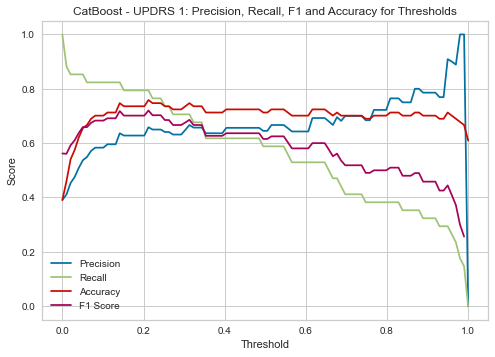

ROC-AUC: 0.7619311875693674 
Accuracy: 0.7586206896551724 
Precision: 0.6585365853658537 
Recall: 0.7941176470588235 
Threshold: 0.21


In [266]:
# Load the saved model
model = joblib.load('../models/catboost_updrs_1_model_max_depth_meds.pkl')

# Make predictions on the test data
X_test1 = updrs1_yr_test.drop(columns=['updrs_1_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_1'])
y_test1 = updrs1_yr_test['updrs_1_cat']

preds = model.predict_proba(X_test1)[:, 1]


plot_precision_recall_accuracy(y_test1, preds, 'UPDRS 1', 'CatBoost')

print("ROC-AUC:", roc_auc_score(y_test1, preds),\
    "\nAccuracy:", accuracy_score(y_test1, preds>0.21), \
    "\nPrecision:", precision_score(y_test1, preds>0.21), \
    "\nRecall:", recall_score(y_test1, preds>0.21), \
    "\nThreshold: 0.21")

c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


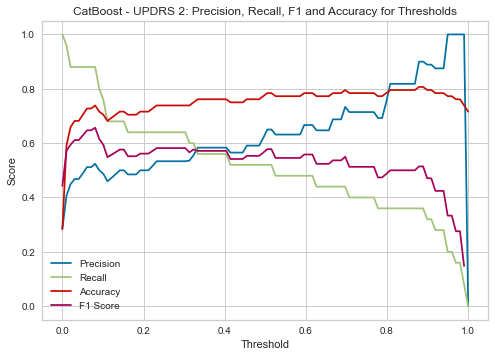

ROC-AUC: 0.8285714285714286 
Accuracy: 0.7045454545454546 
Precision: 0.48717948717948717 
Recall: 0.76 
Threshold: 0.1


In [267]:
# Load the saved model
model = joblib.load('../models/catboost_updrs_2_model_max_depth_meds.pkl')

# Make predictions on the test data
X_test2 = updrs2_yr_test.drop(columns=['updrs_2_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_2'])
y_test2 = updrs2_yr_test['updrs_2_cat']

preds = model.predict_proba(X_test2)[:, 1]


plot_precision_recall_accuracy(y_test2, preds, 'UPDRS 2', 'CatBoost')

print("ROC-AUC:", roc_auc_score(y_test2, preds),\
    "\nAccuracy:", accuracy_score(y_test2, preds>0.1), \
    "\nPrecision:", precision_score(y_test2, preds>0.1), \
    "\nRecall:", recall_score(y_test2, preds>0.1), \
    "\nThreshold: 0.1")

c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


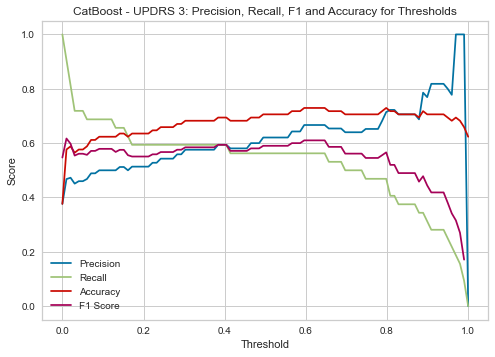

ROC-AUC: 0.714622641509434 
Accuracy: 0.6235294117647059 
Precision: 0.5 
Recall: 0.6875 
Threshold: 0.11


In [268]:
# Load the saved model
model = joblib.load('../models/catboost_updrs_3_model_max_depth_meds.pkl')

# Make predictions on the test data
X_test3 = updrs3_yr_test.drop(columns=['updrs_3_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_3'])
y_test3 = updrs3_yr_test['updrs_3_cat']

preds = model.predict_proba(X_test3)[:, 1]


plot_precision_recall_accuracy(y_test3, preds, 'UPDRS 3', 'CatBoost')

print("ROC-AUC:", roc_auc_score(y_test3, preds),\
    "\nAccuracy:", accuracy_score(y_test3, preds>0.11), \
    "\nPrecision:", precision_score(y_test3, preds>0.11), \
    "\nRecall:", recall_score(y_test3, preds>0.11), \
    "\nThreshold: 0.11")

In [ ]:
def train_catboost(train_df, test_df, updrs):
    features = train_df.drop([f'{updrs}_cat', 'kfold'], axis=1)
    target = train_df[f'{updrs}_cat']
    X_val = val_df.drop([f'{updrs}_cat','kfold'] axis=1)
    y_val = val_df[f'{updrs}_cat']

    # Define the CatBoost classifier
    model = CatBoostClassifier(iterations=1000, eval_metric='AUC', random_seed=42)

    # Fit the model on the training data
    model.fit(features, 
              target,
                #early_stopping_rounds=50, 
                verbose=100)

    # Make predictions on the test data
    predictions = model.predict_proba(test_df)[:, 1]

    # Evaluate AUC on the test data
    auc = roc_auc_score(test_df[f'{updrs}_cat'], predictions)
    print("AUC on Test Data:", auc)

    # Save the best iteration of the model
    model.save_model(f'../models/catboost_{updrs}_model.cbm', format='cbm', pool=None)

    return model

In [ ]:
# train and save the best catboost model for each updrs
cboost_results = dict()

for updrs, df in zip(['updrs_1'], [updrs1_yr_df]):
    model = prepare_catboost_model(cboost_forecast_hyperparams_df, updrs)
    temp_df, test_kfold = create_folds(df, updrs)
    val_kfold = test_kfold - 1 
    temp_df = temp_df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    X_train = temp_df[(temp_df['kfold'] != test_kfold)&(temp_df['kfold']!=val_kfold)].reset_index(drop=True)
    y_train = X_train[f'{updrs}_cat']
    X_test = temp_df[temp_df['kfold'] == test_kfold].reset_index(drop=True)
    y_test = X_test[f'{updrs}_cat']
    val_df = temp_df[temp_df['kfold'] == val_kfold].reset_index(drop=True)
    
    best_model = train_catboost(X_train, val_df, X_test, updrs)
    
    #preds = best_model.predict(X_test.drop(columns = [f'{updrs}_cat', 'kfold']))
    #test_auc = roc_auc_score(y_test, preds)
    #preds = best_model.predict(X_train.drop(columns=[f'{updrs}_cat', 'kfold']))
    #train_auc = roc_auc_score(y_train, preds)
    
    #cboost_results[updrs] = {'test_auc':test_auc, 'train_auc':train_auc}



    

5 Kfolds created for updrs_1_cat
Learning rate set to 0.023058
0:	test: 0.4894349	best: 0.4894349 (0)	total: 279ms	remaining: 4m 38s
100:	test: 0.6599509	best: 0.6633907 (98)	total: 20.3s	remaining: 3m
200:	test: 0.6914005	best: 0.6914005 (169)	total: 38.9s	remaining: 2m 34s
300:	test: 0.7027027	best: 0.7071253 (287)	total: 57.5s	remaining: 2m 13s
400:	test: 0.7115479	best: 0.7154791 (386)	total: 1m 16s	remaining: 1m 53s
500:	test: 0.7159705	best: 0.7169533 (477)	total: 1m 34s	remaining: 1m 34s
600:	test: 0.7130221	best: 0.7169533 (477)	total: 1m 53s	remaining: 1m 15s
700:	test: 0.7135135	best: 0.7169533 (477)	total: 2m 11s	remaining: 56.3s
800:	test: 0.7233415	best: 0.7243243 (785)	total: 2m 30s	remaining: 37.4s
900:	test: 0.7233415	best: 0.7248157 (808)	total: 2m 49s	remaining: 18.6s
999:	test: 0.7267813	best: 0.7272727 (960)	total: 3m 7s	remaining: 0us

bestTest = 0.7272727273
bestIteration = 960

Shrink model to first 961 iterations.
AUC on Test Data: 0.7326781326781326


In [ ]:
# compare the results of the model
test_preds = best_model.predict(X_test)
test_auc = roc_auc_score(y_test, test_preds)
train_preds = best_model.predict(X_train)
train_auc = roc_auc_score(y_train, train_preds)
test_auc, train_auc

(0.6525798525798526, 1.0)

In [ ]:
for updrs, df in zip(['updrs_2'], [updrs2_yr_df]):
    model = prepare_catboost_model(cboost_forecast_hyperparams_df, updrs)
    temp_df, test_kfold = create_folds(df, updrs)
    val_kfold = test_kfold - 1 
    temp_df = temp_df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    X_train = temp_df[(temp_df['kfold'] != test_kfold)&(temp_df['kfold']!=val_kfold)].reset_index(drop=True)
    y_train = X_train[f'{updrs}_cat']
    X_test = temp_df[temp_df['kfold'] == test_kfold].reset_index(drop=True)
    y_test = X_test[f'{updrs}_cat']
    val_df = temp_df[temp_df['kfold'] == val_kfold].reset_index(drop=True)
    
    best_model = train_catboost(X_train, val_df, X_test, updrs)
    
    #preds = best_model.predict(X_test.drop(columns = [f'{updrs}_cat', 'kfold']))
    #test_auc = roc_auc_score(y_test, preds)
    #preds = best_model.predict(X_train.drop(columns=[f'{updrs}_cat', 'kfold']))
    #train_auc = roc_auc_score(y_train, preds)
    
    #cboost_results[updrs] = {'test_auc':test_auc, 'train_auc':train_auc}

5 Kfolds created for updrs_2_cat
Learning rate set to 0.023058
0:	test: 0.5623974	best: 0.5623974 (0)	total: 206ms	remaining: 3m 26s
100:	test: 0.7695676	best: 0.7766831 (95)	total: 18.2s	remaining: 2m 42s
200:	test: 0.7996716	best: 0.8111658 (176)	total: 36.1s	remaining: 2m 23s
300:	test: 0.8292282	best: 0.8314176 (299)	total: 54.1s	remaining: 2m 5s
400:	test: 0.8445539	best: 0.8467433 (381)	total: 1m 12s	remaining: 1m 48s
500:	test: 0.8494800	best: 0.8549535 (464)	total: 1m 30s	remaining: 1m 29s
600:	test: 0.8560482	best: 0.8565955 (581)	total: 1m 48s	remaining: 1m 11s
700:	test: 0.8555008	best: 0.8582375 (674)	total: 2m 6s	remaining: 54s
800:	test: 0.8587849	best: 0.8587849 (738)	total: 2m 26s	remaining: 36.4s
900:	test: 0.8576902	best: 0.8593322 (804)	total: 2m 45s	remaining: 18.2s
999:	test: 0.8587849	best: 0.8604269 (946)	total: 3m 4s	remaining: 0us

bestTest = 0.8604269294
bestIteration = 946

Shrink model to first 947 iterations.
AUC on Test Data: 0.8292282430213465


In [ ]:
# compare the results of the model
test_preds = best_model.predict(X_test)
test_auc = roc_auc_score(y_test, test_preds)
train_preds = best_model.predict(X_train)
train_auc = roc_auc_score(y_train, train_preds)
test_auc, train_auc

(0.6737821565407772, 1.0)

In [ ]:
for updrs, df in zip(['updrs_3'], [updrs3_yr_df]):
    model = prepare_catboost_model(cboost_forecast_hyperparams_df, updrs)
    temp_df, test_kfold = create_folds(df, updrs)
    val_kfold = test_kfold - 1 
    temp_df = temp_df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    X_train = temp_df[(temp_df['kfold'] != test_kfold)&(temp_df['kfold']!=val_kfold)].reset_index(drop=True)
    y_train = X_train[f'{updrs}_cat']
    X_test = temp_df[temp_df['kfold'] == test_kfold].reset_index(drop=True)
    y_test = X_test[f'{updrs}_cat']
    val_df = temp_df[temp_df['kfold'] == val_kfold].reset_index(drop=True)
    
    best_model = train_catboost(X_train, val_df, X_test, updrs)
    
    #preds = best_model.predict(X_test.drop(columns = [f'{updrs}_cat', 'kfold']))
    #test_auc = roc_auc_score(y_test, preds)
    #preds = best_model.predict(X_train.drop(columns=[f'{updrs}_cat', 'kfold']))
    #train_auc = roc_auc_score(y_train, preds)
    
    #cboost_results[updrs] = {'test_auc':test_auc, 'train_auc':train_auc}

5 Kfolds created for updrs_3_cat
Learning rate set to 0.023037
0:	test: 0.5795918	best: 0.5795918 (0)	total: 212ms	remaining: 3m 32s
100:	test: 0.6540816	best: 0.6709184 (92)	total: 19s	remaining: 2m 49s
200:	test: 0.6943878	best: 0.6989796 (191)	total: 40.1s	remaining: 2m 39s
300:	test: 0.7306122	best: 0.7311224 (294)	total: 1m 1s	remaining: 2m 23s
400:	test: 0.7372449	best: 0.7403061 (359)	total: 1m 22s	remaining: 2m 3s
500:	test: 0.7494898	best: 0.7510204 (493)	total: 1m 39s	remaining: 1m 39s
600:	test: 0.7530612	best: 0.7556122 (572)	total: 1m 56s	remaining: 1m 17s
700:	test: 0.7551020	best: 0.7571429 (689)	total: 2m 13s	remaining: 57s
800:	test: 0.7586735	best: 0.7602041 (780)	total: 2m 30s	remaining: 37.4s
900:	test: 0.7576531	best: 0.7612245 (822)	total: 2m 47s	remaining: 18.4s
999:	test: 0.7596939	best: 0.7612245 (822)	total: 3m 4s	remaining: 0us

bestTest = 0.7612244898
bestIteration = 822

Shrink model to first 823 iterations.
AUC on Test Data: 0.7775510204081633


In [ ]:
# compare the results of the model
test_preds = best_model.predict(X_test)
test_auc = roc_auc_score(y_test, test_preds)
train_preds = best_model.predict(X_train)
train_auc = roc_auc_score(y_train, train_preds)
test_auc, train_auc

(0.6303571428571428, 1.0)

## Compare to Logistic Regression Model

In [ ]:
model = LogisticRegression()

# run cross fold validation on the updrs 1 data
updrs1_results = cross_fold_validation(updrs1_df, model, 'updrs_1')

model = LogisticRegression()
updrs2_results = cross_fold_validation(updrs2_df, model, 'updrs_2')

model = LogisticRegression()
updrs3_results = cross_fold_validation(updrs3_df, model, 'updrs_3')

c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

In [ ]:
updrs1_results

(0.511721383287093,
 0.780847703040674,
 0.32282051282051283,
 0.062211088895139766)

In [ ]:
updrs2_results

(0.5258909849605227,
 0.8464349962704578,
 0.42333333333333323,
 0.07048988874546684)

In [ ]:
updrs3_results

(0.5240749211448716,
 0.8194894035589735,
 0.3485714285714286,
 0.07900396151669495)

## Forecast with Logistic Regression

In [ ]:
model = LogisticRegression()

# run cross fold validation on the updrs 1 data
updrs1_forecast_results = cross_fold_validation(updrs1_yr_df, model, 'updrs_1')

model = LogisticRegression()
updrs2_forecast_results = cross_fold_validation(updrs2_yr_df, model, 'updrs_2')

model = LogisticRegression()
updrs3_forecast_results = cross_fold_validation(updrs3_yr_df, model, 'updrs_3')

c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

In [ ]:
updrs1_forecast_results

(0.5634874999789138,
 0.5994172665293609,
 0.4912421630094044,
 0.3920253253358589)

In [ ]:
updrs2_forecast_results

(0.582742150911908, 0.6805340492840493, 0.4779128959276018, 0.3289821193299454)

In [ ]:
updrs3_forecast_results

(0.5758538282007636,
 0.6218648310387985,
 0.5047414576826341,
 0.3744481451117032)